In [1]:
import time
import sys
sys.path.append("..")
from MTRT import *
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from LGSM import LGSM
from datetime import datetime
from DEORtool import DEOR_tool as dt
from DEORtool import EoRmod
from DEORtool import DEOR_simulation
from cbeam import cbeam
from MTRT import Bv
import csv
from IPython.display import Latex
from scipy.interpolate import interp1d
from matplotlib import cm
from MTRT import QAQ
from MTRT import cof

In [2]:
data = []
csv_reader = csv.reader(open("data1.csv"))
for line in csv_reader:
    data.append(line)

In [3]:
head = np.float64(data[1])
thetal = np.float64(data[2])
phil = np.float64(data[3])
m = np.float64(data[4])
positions = np.int64(data[5])

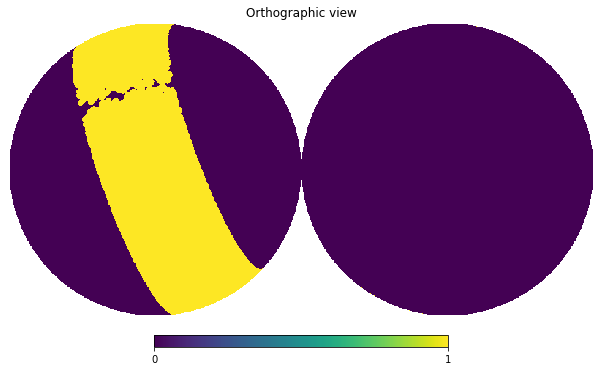

In [4]:
# NSIDE = 2**9
# V = hp.ang2vec(4*np.pi/5,0)
# ip = hp.query_disc(nside=NSIDE, vec=V, radius=np.radians(10) )
# m[ip] = 0
hp.orthview(m)

In [5]:
# 设置流星参数，流星方向向量
mt_theta = head[0] #天顶距
mt_phi = head[1] #方位角
# 距离坐标单位为km
mt_origin = [head[2],head[3],head[4]]
Length = head[5]
mt = MeteorTrail(mt_origin,mt_theta,mt_phi,length=Length)
Mm = mt.get_zvector()
#print(Mm)
wl_origin = mt.trans_origin()
#print(wl_origin)
Mt_position = mt.end
Mt_RP = (np.array(mt_origin)+Mt_position)/2
#print("Meteor cenetr to origin: ",Mt_RP)
# 流星中点到原点的距离，用于计算功率
Mt_R = np.dot(Mt_RP,Mt_RP)**0.5*1000
#print(Mt_R)
#print(Mt_position)
# 得到local坐标系的基
localx,localy,localz = getwl(Mm,mt_origin)
#print(localx,localy,localz)

mtheta,mphi = MTvec2ang(mt_origin[0],mt_origin[1],mt_origin[2])
print("Meteor start point coords: ",mtheta*180/np.pi,mphi*180/np.pi)
Mtheta,Mphi = MTvec2ang(Mt_position[0],Mt_position[1],Mt_position[2])
print("Meteor end point coords: ",Mtheta*180/np.pi,Mphi*180/np.pi)

# m是流星原点，M是流星终点
# mx，my是流星原点在天球圆投影坐标， Mx，My同理
mx = -np.sin(mtheta)*np.cos(mphi)
Mx = -np.sin(Mtheta)*np.cos(Mphi)

my = np.sin(mtheta)*np.sin(mphi)
My = np.sin(Mtheta)*np.sin(Mphi)

Meteor start point coords:  40.951625115102296 39.80557109226519
Meteor end point coords:  36.97432181323711 100.33595129669784


In [6]:
#流星余迹a （h,theta_f,phi_f）
#流星位置M（R,theta_m,phi_m）
#求a0c0 theta_q,phi_q
theta_m = (mx+Mx)/2
phi_m = (my+My)/2
h = head[5]*np.cos(np.pi*head[0]/180)/2 + head[4]
theta_f = np.pi*head[0]/180
if np.pi*head[1]/180 >= np.pi:
    phi_f = np.pi*head[1]/180 - np.pi
else:
    phi_f = np.pi*head[1]/180 + np.pi
x_m = head[2] + np.cos(np.pi*head[1]/180)*theta_f*head[5]/2
y_m = head[3] + np.sin(np.pi*head[1]/180)*theta_f*head[5]/2

R = np.sqrt(x_m**2 +y_m**2 + h**2)
# print(x_m,y_m,R)
# print(180*theta_f/np.pi,180*phi_f/np.pi,h)

In [7]:
# x = -np.sin(thetal)*np.cos(phil)
# y = np.sin(thetal)*np.sin(phil)
# z = np.cos(thetal)

# fig = plt.figure(figsize=(14,14))
# ax = fig.add_subplot(111)
# cir1 = plt.Circle(xy=(0.0,0.0),radius=1,alpha=0.2)

# markers = ["$N$","$S$","$W$","$E$"]

# plt.text(-1,0.85,'Direction:Theta = %d° Phi= %d°\nPosition:x=%dkm,y=%dkm\nAltitude:%dkm\nLength:%dkm'%(mt_theta,mt_phi,mt_origin[0],mt_origin[1],mt_origin[2],Length),fontsize=15)
# plt.scatter(x,y,c='y',s=5)

# plt.scatter(0,0,marker="*",color="r",s=200,label="zenith")
# plt.scatter(0,1,marker=markers[0],color="r",s=200)
# plt.scatter(0,-1,marker=markers[1],color="r",s=200)
# plt.scatter(1,0,marker=markers[2],color="r",s=200)
# plt.scatter(-1,0,marker=markers[3],color="r",s=200)

# plt.plot([mx,Mx],[my,My],linewidth=6,label="Meteor trail\nproject at sky")
# plt.scatter(theta_m,phi_m,marker='*',color="r",s=200)

# plt.xlim(-1.05,1.05)
# plt.ylim(-1.05,1.05)

# plt.xticks([])
# plt.yticks([])

# ax.add_patch(cir1)
# plt.legend(fontsize=15,loc='best')
# #plt.title("Sky View",fontsize=26)

In [8]:
#计算a0 c0

a0 = R*np.sqrt(1-(np.sin(theta_m)*np.sin(phi_m-phi_f)*np.sin(theta_f)+np.cos(theta_m)*np.cos(theta_f))**2)
c0 = -R*(np.sin(theta_m)*np.sin(phi_m-phi_f)*np.sin(theta_f)+np.cos(theta_m)*np.cos(theta_f))
#print(a0,c0)

In [9]:
theta_q,phi_q = QAQ(thetal,phil,theta_f,phi_f,theta_m,phi_m)

/home/zfy/pygdsm/pygdsm/raytracing/MTRT.py:35: RuntimeWarning: divide by zero encountered in true_divide
  phi_q = np.arctan((np.sin(theta_q1)*np.cos(phi_f-phi_q1)*np.cos(theta_f)-np.cos(theta_q1)*np.sin(theta_f))/(np.sin(theta_q1)*np.sin(phi_f-phi_q1)))-np.arctan((-np.sin(theta_m)*np.sin(phi_m-phi_f)*np.cos(theta_f)+np.cos(theta_m)*np.sin(theta_f))/(np.sin(theta_m)*np.sin(phi_m-phi_f)))


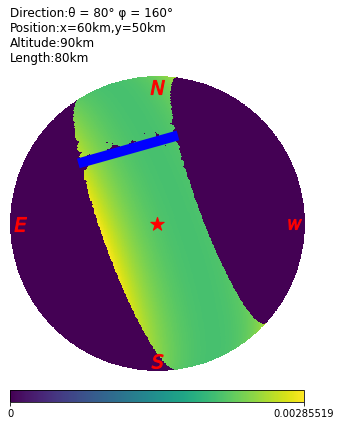

In [10]:
freq = 20
lam = 3e8/(freq*10**6)
k = cof(theta_q,phi_q,lam,R)
m[positions] = k
hp.orthview(m,half_sky=True,title='')
markers = ["$N$","$S$","$W$","$E$"]
plt.plot([mx,Mx],[my,My],color='b',linewidth=10,label="Meteor trail\nproject at sky")
plt.scatter(0,0,marker="*",color="r",s=200,label="zenith")
plt.scatter(0,0.93,marker=markers[0],color="r",s=200)
plt.scatter(0,-0.93,marker=markers[1],color="r",s=200)
plt.scatter(0.93,0,marker=markers[2],color="r",s=200)
plt.scatter(-0.93,0,marker=markers[3],color="r",s=200)
plt.text(-1,1.1,'Direction:θ = %d° φ = %d°\nPosition:x=%dkm,y=%dkm\nAltitude:%dkm\nLength:%dkm'%(mt_theta,mt_phi,mt_origin[0],mt_origin[1],mt_origin[2],Length),fontsize=12)
#plt.savefig('figure8',bbox_inches = 'tight',dpi=300)
plt.show()

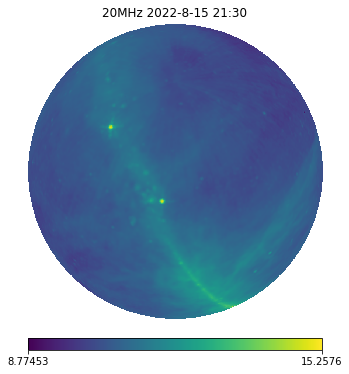

In [11]:
NSIDE = 2**9
sky1 = LGSM()
freqs = np.arange(20,100,1)
#生成一个XXMHz的天图并查看
sky1.generate(freqs)
#sky1.view(logged=True)
#设定经纬度与时间
(latitude, longitude, elevation) = ('52.9', '6.9', 100)
sky1.lon = longitude
sky1.lat = latitude
sky1.elev = elevation
sky1.date = datetime(2022, 8, 15, 21, 30)
O_sky = sky1.masks_sky()#生成一个设定观测地点时间的实际观测天图，数据为第一步时生成的
hp.orthview(np.log(O_sky[1]),half_sky=True,title='20MHz 2022-8-15 21:30')
#plt.savefig('obssky',dpi=300)

In [12]:
R_c = []
Flux = []
for i in range(len(freqs)):
    lmd = 3e8/(freqs[i]*10**6)
    k = cof(theta_q,phi_q,lmd,R,q=10**14)
    R_c.append(k)
    res = dt.P2Jy(dt.T2P(NSIDE,np.array(O_sky[i]),freqs[i]))
    flux = np.sum(res[positions]*k)
    Flux.append(flux)

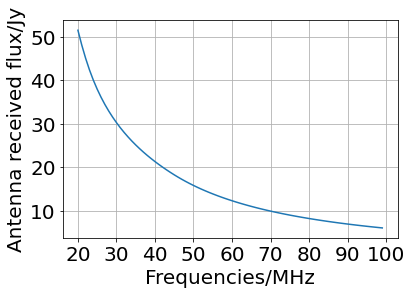

In [13]:
plt.plot(freqs,Flux)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.title("Fixed MT changes the antenna\n temperture vs frequencies",fontsize=24)
plt.ylabel("Antenna received flux/Jy",fontsize=20)
plt.xlabel("Frequencies/MHz",fontsize=20)
#plt.legend(prop = {'size':13})
plt.grid()
plt.show()

In [14]:
sky2 = LGSM()
#生成一个100MHz的天图并查看
freq = 40
sky2.generate(freq)
#sky2.view(logged=True)

hours = np.arange(0,24,1)
mins = np.arange(0,60,20)

#设定经纬度与时间
(latitude, longitude, elevation) = ('52.9', '6.9', 100)
sky2.lon = longitude
sky2.lat = latitude
sky2.elev = elevation

Prl = []
time_list = []
for i in hours:
    for j in mins:
        sky2.date = datetime(2022, 8, 15, i, j)
        O_sky = sky2.mask_sky()
        signal = O_sky.data*m
        time_list.append(i+j/60)
        Pr = 0
        lmd = 3e8/(40*10**6)
        k = cof(theta_q,phi_q,lmd,R)
        res = dt.P2Jy(dt.T2P(NSIDE,np.array(O_sky),40))
        Pr = np.sum(res[positions]*k)
        #print(Pr)
        Prl.append(Pr)

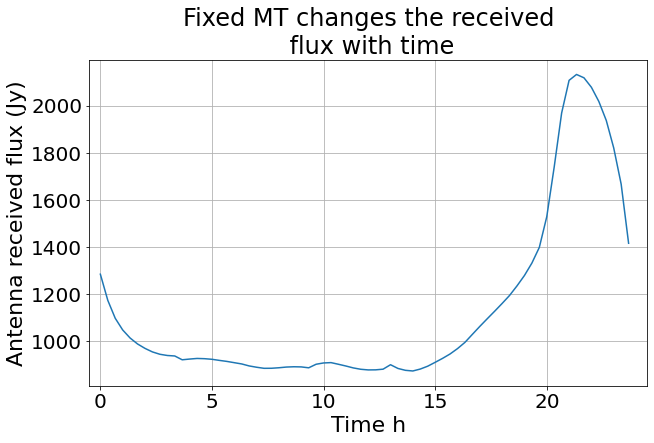

In [15]:
fig = plt.figure(figsize=(10,6))
plt.plot(time_list,np.array(Prl))

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(-0.5,24.5)

plt.title("Fixed MT changes the received\n flux with time",fontsize=24)
plt.ylabel("Antenna received flux (Jy)",fontsize=22)
plt.xlabel("Time h",fontsize=22)

plt.grid()

#plt.savefig("/home/jiomer/Documents/pygdsm/DEoRtool/meteor_fig/"+file_name+"-fluxtime.png",dpi=200)
plt.show()

In [16]:
with open("result1b.csv","w") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows([freqs,Flux,time_list,np.array(Prl)])